# FHR Baseline from Maeda et al. 2012

## Summary

This notebook implements the method for FHR baseline calculation from Maeda et al. 2012, based on the MATLAB implemention in the FHRMA package.

The paper: [Maeda et al. 2012](https://benthamopen.com/contents/pdf/TOMDJ/TOMDJ-4-28.pdf) - Central Computerized Automatic Fetal Heart Rate Diagnosis with a Rapid and Direct Alarm System

This method is **successfully implemented** - all records match between Python and MATLAB.

**Observations:**
* This method used modes, but that meant the baseline FHR would vary quite notably if the mode changed (as it's not uncommon for it to be a close call between modes). For example, which mode is chosen in a multi-mode situation. I have found examples where FHRMA was the min and examples where it was the max.
* The FHRMA/MATLAB implementation sometimes differed from my interpretation of the paper description. I noticed this to be the case for:
    * Calculation of mean from all values in bin rather than 5-minute interval values in bin (as I think it makes sense it would be the interval)
    * Calculation of fHR for last interval using points from the previous interval to pad to 150 (as I have not found mention of this in the paper - but its not implausible)

## Paper description of the method

FHR was sampled every 250ms over a 5-minute period, and averaged every 2 seconds to determine 150 FHR (also found 150 uterine contraction data) (as there are 30 x 2 seconds in a minute, so 150 x 2 seconds in 5 minutes). FHR data were counted in intervals of 10 beats per minute (bpm) ranging from 0 to 200 bpm. The data in the interval with the most frequent FHR data was then averaged to determine the FHR baseline. 

So basically...

1. **Find the average of every 2 seconds**

2. **Look at data from a five minute period** - this will mean you are looking at a sample of 150 FHR (as each represents average of 2 seconds, and there are 150 x 2 seconds in 5 minutes)

3. **Look at frequency of data in bins of 10bpm** - i.e. number of FHR that are 140-149.99, 150-150.99, and so on.

4. **Find the most frequent bin** - for example, 140-150 has the most records, then just use the data from that bin

5. **Find the average of the heartrates from that bin** - so might get a result like 145.5, or so on. That represents the baseline FHR for that 5 minute portion of the data.

### MATLAB Implementation

Boudet et al. implement this method [in the FHRMA toolbox using MATLAB](https://github.com/utsb-fmm/FHRMA/blob/master/aammaeda.m).

They used a function `aamaeda.m` with the relevant excerpt copied below:

```
sFHR=avgsubsamp(FHR,8);
baseline=zeros(1,length(FHR));

for win=[0:150:length(sFHR)-151 length(sFHR)-150]
    
    bins=zeros(1,25);

    for i=1:150
        bins(ceil(sFHR(win+i)/10))=bins(ceil(sFHR(win+i)/10))+1;
    end
    [~,bestbins]=max(bins(1:20));
    
    baseline(win*8+1:win*8+1200)=mean(sFHR( sFHR<=bestbins*10 & sFHR>(bestbins-1)*10 ));

end


baseline(win*8+1201:length(FHR))=baseline(win*8+1200);
```

Within that, they use a function `avgsubsamp` for subsampling by average, which is also copied below:

```
function y=avgsubsamp(x,factor)
    y=zeros(1,floor(length(x)/factor));
    for i=1:length(y)
        y(i)=mean(x((i-1)*factor+1:i*factor));
    end
end
```

## Python implementation

### Set up

Import required packages

In [1]:
# Import packages
import copy
from dataclasses import dataclass
import glob
from itertools import compress, groupby
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
from scipy import io
from statistics import multimode

Define file paths

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    clean_fhr = './data/clean_fhr_matlab/'
    md_std = './data/MD_std.mat'


paths = Paths()

Define function for importing all csv files in a directory

In [3]:
def import_csv(directory, output_dict):
    '''
    Import csv files from provided directory and save to output_dict
    Inputs:
    directory - string, location of csv files
    output_dict - dictionary, to save files to
    '''
    # Get list of .csv files in directory
    files = glob.glob(os.path.join(directory, '*.csv'))

    # Loop through files in the directory
    for file in files:
        # Get raw name of record (without path or file type)
        name = file.replace(directory, '').replace('.csv', '')
        # Import and save to dictionary
        output_dict[name] = pd.read_csv(file, header=None)[0].values

    return output_dict

Load the cleaned FHR data

In [4]:
raw_fhr = import_csv(
    directory=paths.clean_fhr,
    output_dict=dict())

Load the results when processed using Maeda's methodology in FHRMA

In [5]:
# Load FHRMA version of results
md_std = io.loadmat(paths.md_std)

# Get array listing filenames (and hence order of the data)
fhrma_files = np.concatenate(np.concatenate(md_std['data']['filename']))

# Get array with the baseline signal as per Maeda when implemented in FHRMA
fhrma_md = np.concatenate(md_std['data']['baseline'])
# Convert array into dictionary so each record is accompanied by relevant name
fhrma_maeda_base = {
    fhrma_files[i].replace('.fhr', ''): 
    fhrma_md[i][0] for i in range(len(fhrma_files))}

### Define function for baseline calculation

Steps:

1. **Convert to average of every 2 seconds** - In FHRMA, they seperate the FHR into chunks of 8 (i.e. first 8 records, then next 8, then next 8, and so on). They then find the mean of each of those chunks.

2. **Find the most common heartrate bin in each 5 minute interval** - We're looking at every 5 minutes / 300 seconds (which equates to 150 of the 2 second results). We sort the heartrates into bins of 10bpm (e.g. 130-140, 140-150, 150-160), then look to see which bin is most common for that 5 minute period. FHRMA then find the mean of all heartrates from that bin across the entire recorded FHR CTG, but I am minded to suggested that this should be the mean of only the heartrates from that bin in the current five minute interval.

Note: This doesn't clean FHR beforehand, so could include large periods of 0, and includes values outside of normal.

In [6]:
def get_baseline(fhr, match_fhrma, show_process=False):
    '''
    Get FHR baseline using method from Maeda et al. 2012.

    Parameters
    ----------
    fhr : array
        Raw FHR sampled at 4Hz
    match_fhrma : boolean
        Whether to use a method that ensures results match FHRMA implementation
        of Maeda's method, or whether to use the method that I currently think
        best matches the description/intention in the original paper
    show_process : boolean
        Whether to print results as move through this process

    Return
    ------
    baseline : array
        Array where raw FHR is replaced by the baseline FHR calculated for the
        five minute interval which it belonged to
    '''
    # Create array of zeros of length of fhr, which will amend to store baseline
    baseline = [0] * len(fhr)

    # Find mean of every 8 records, generating shorter version of FHR (sfhr)
    sfhr = []
    start=0
    end=len(fhr)
    step=8
    for i in range(start, end, step):
        sfhr.append(np.mean(fhr[i:i+step]))

    # If there is a remainder when divide length by 8 (i.e. doesn't perfectly
    # divide), then drop the final calculated FHR, as it is not from at least 8 data points
    if len(fhr) % 8 != 0:
        sfhr.pop()

    # Print example of results
    if show_process:
        print(f'First 16 records in raw FHR: {fhr[:16]}')
        print(f'First 2 records in shortened FHR (average of each 8): {sfhr[:2]}')

    # Split the record into 5 minute intervals (if last less than 5 min, will be 
    # smaller). Loop through each interval
    starts = np.append(np.arange(0, len(sfhr)-150, 150), [len(sfhr)-150])
    for i in starts:

        # If want to match results in FHRMA, for the final interval, filter to
        # the last 5 minutes of the data, even if that overlaps with the
        # previous 5 minute segment
        if match_fhrma:
            current = sfhr[0+i:150+i]
            if len(current) < 150:
                current = sfhr[-150:]
        # Otherwise, allow the last segment to be less than 5 minutes
        else:
            # Filter data to that 5-minute segment
            current = sfhr[0+i:150+i]

        # Convert each record into their upper bin boundary (e.g. 149 --> 150)
        bins = np.array([math.ceil(x/10)*10 for x in current])
        # Restrict to only bins that are between 0 and 200
        bins = [x for x in bins if x <= 200]

        # Find the most common bin - in multi-mode situations, take minimum
        modes = multimode(bins)
        most_common = min(modes)
        if show_process:
            print(modes)
            print(most_common)

        # If want to match results in FHRMA, filter to records from that bin
        # from across the entire CTG
        if match_fhrma:
            mask = [(x <= most_common) & (x > most_common-10) for x in sfhr]
            filtered = list(compress(sfhr, mask))
        # Otherwise, filter to records in that bin from only that 5min interval
        else:
            mask = [(x <= most_common) & (x > most_common-10) for x in current]
            filtered = list(compress(current, mask))

        # Find mean of those filtered records in that bin
        mean = np.mean(filtered)

        # Set the records in baseline for that five minute interval to this mean
        baseline[(i*8):1200+(i*8)] = [mean] * 1200

    # Get the last value from the last interval, and set all subsequent points to that value
    baseline[i*8+1200:] = [baseline[i*8+1200-1]]*len(baseline[i*8+1200:])

    # Print example of results from final run of that loop above
    if show_process:
        print(f'First 10 records of one of the intervals: {current[:10]}')
        print(f'Conversion of those records to bins: {bins[:10]}')
        print(f'Most common bin in the whole 5 minute interval: {most_common}')
        print(f'Calculated baseline FHR for that interval: {mean}')

    return(baseline)

In [7]:
# Load an example...
record = 'test04'

# FHR signal
fhr = pd.read_csv(os.path.join(paths.clean_fhr, f'{record}.csv'),
                  header=None)[0].values

# Create array of zeros of length of fhr, which will amend to store baseline
baseline = [0] * len(fhr)

# Find mean of every 8 records, generating shorter version of FHR (sfhr)
sfhr = []
start=0
end=len(fhr)
step=8
for i in range(start, end, step):
    sfhr.append(np.mean(fhr[i:i+step]))

# If there is a remainder when divide length by 8 (i.e. doesn't perfectly
# divide), then drop the final calculated FHR, as it is not from at least 8 data points
if len(fhr) % 8 != 0:
    sfhr.pop()

# Split the record into 5 minute intervals (if last less than 5 min, will be 
# smaller). Loop through each interval
starts = np.append(np.arange(0, len(sfhr)-150, 150), [len(sfhr)-150])
starts

array([   0,  150,  300,  450,  600,  750,  900, 1050, 1200, 1350, 1500,
       1650, 1800, 1950, 2100, 2250, 2400, 2539])

### Compare one example to FHRMA

In [8]:
# Load an example...
record = 'test04'

# FHR signal
fhr = pd.read_csv(os.path.join(paths.clean_fhr, f'{record}.csv'),
                  header=None)[0].values

# Results from Python
python_result = get_baseline(fhr, match_fhrma=True, show_process=False)

# Result from FHRMA
fhrma_result = fhrma_maeda_base[record]

# Show differences
display('Python result:')
display([(k, sum(1 for i in g)) for k,g in groupby(python_result)])
display('FHRMA result:')
display([(k, sum(1 for i in g)) for k,g in groupby(fhrma_result)])

print('Overall mean of each:')
print(np.mean(python_result))
print(np.mean(fhrma_result))

print('Length of each:')
print(len(python_result))
print(len(fhrma_result))

'Python result:'

[(125.3006804441638, 4800),
 (153.65487052485227, 1200),
 (135.12338322738472, 1200),
 (144.52495630490108, 2400),
 (135.12338322738472, 1200),
 (125.3006804441638, 1200),
 (135.12338322738472, 6000),
 (144.52495630490108, 3517)]

'FHRMA result:'

[(125.30068044416383, 4800),
 (153.65487052485227, 1200),
 (135.1233832273847, 1200),
 (144.52495630490105, 2400),
 (135.1233832273847, 1200),
 (125.30068044416383, 1200),
 (135.1233832273847, 6000),
 (144.52495630490105, 3517)]

Overall mean of each:
136.00318412701296
136.00318412701287
Length of each:
21517
21517


### Test on all available FHRMA data and compare against their results

For this, I took the overall mean from the baseline record (rather than comparing each of the 5-minute means).

First, run all FHR through the baseline function and store results.

In [9]:
# Create dictionary to store results
python_maeda = dict()

for key, value in raw_fhr.items():
    python_maeda[key] = get_baseline(value, match_fhrma=True, show_process=False)

Then find the overall mean of each record and combine the results from python, octave and the FHRMA into a single dataframe.

In [10]:
# Find mean of each record
python_df = pd.DataFrame({
    'record': python_maeda.keys(),
    'python_mean': [round(np.mean(python_maeda[i]),10) for i in python_maeda.keys()]})
fhrma_df = pd.DataFrame({
    'record': fhrma_maeda_base.keys(),
    'fhrma_mean': [round(np.mean(fhrma_maeda_base[i]),10) for i in fhrma_maeda_base.keys()]})

# Combine into a single dataframe
compare_mean = pd.merge(python_df, fhrma_df, on='record')

# Add column with difference in means
compare_mean['diff'] = abs(compare_mean['python_mean'] - compare_mean['fhrma_mean'])

Then define a function for displaying the differences.

In [11]:
def compare_means(df, x, y, title):
    '''
    Create scatterpol comparing two columns from df.
    Inputs:
    df - dataframe, to plot from
    x - string, name of column for x axis
    y - string, name of column for y axis
    '''
    fig, ax = plt.subplots()
    ax.scatter(x=df[x], y=df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid()
    ax.set_box_aspect(1)
    plt.show()

Compare Python and FHRMA

,record,python_mean,fhrma_mean,diff
0,train28,124.594527,124.594527,0.0
107,train51,176.449191,176.449191,0.0
100,train09,172.760367,172.760367,0.0
101,test87,146.004686,146.004686,0.0
102,train02,156.746943,156.746943,0.0


diff
True    156
Name: count, dtype: int64

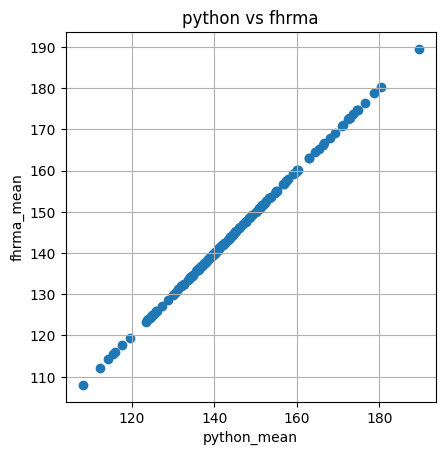

In [12]:
# Preview dataframe, starting with records with the greatest difference
display(compare_mean.sort_values(by='diff', ascending=False).head())

# Record how many are exactly the same
display((compare_mean['diff'] == 0).value_counts())

# Present in a figure
compare_means(compare_mean, 'python_mean', 'fhrma_mean', 'python vs fhrma')